In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)
print("Terminer")

Using Colab cache for faster access to the 'cell-images-for-detecting-malaria' dataset.
Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria
Terminer


**Importation des bibliothèque**

Ici, nous importons les bibliothèques Python nécessaires. Nous utilisons PyTorch (torch), qui est le moteur de notre intelligence artificielle, et Matplotlib pour tracer des graphiques. Une partie importante de ce code est la détection du device : le code vérifie si vous avez une carte graphique puissante (GPU) pour accélérer les calculs. Sinon, il utilisera le processeur classique (CPU).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
import random
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de : {device}")

Utilisation de : cpu


**Chargement et transformation**

Les ordinateurs ont besoin d'ordre. Ici, nous faisons deux choses cruciales :

    Redimensionnement : Nous forçons toutes les images à faire exactement 64x64 pixels pour qu'elles soient compatibles avec le modèle.

    Division : Nous séparons nos images en deux groupes. 80% serviront à l'entraînement (le modèle apprend avec elles) et 20% serviront à la validation (l'examen final pour vérifier si le modèle a bien appris sans tricher).

In [ ]:
# Chemin vers les données
data_dir = f'{path}/cell_images/cell_images'

# 1. Définir les transformations (Redimensionner en 64x64 et convertir en Tenseur)
transform = transforms.Compose([
    transforms.Resize((64, 64)), # On réduit la taille pour aller plus vite
    transforms.ToTensor()        # Convertit l'image en matrice de chiffres
])

# 2. Charger le dossier complet
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 3. Séparer Entraînement (80%) et Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

# 4. Créer les chargeurs (DataLoaders) qui envoient les données par paquets (batchs)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

print(f"Images d'entraînement : {len(train_data)}")
print(f"Images de validation : {len(val_data)}")
print(f"Classes : {full_dataset.classes}")

Images d'entraînement : 22046
Images de validation : 5512
Classes : ['Parasitized', 'Uninfected']


**Visualisation directe**

Avant de coder l'IA, il faut comprendre ce qu'elle doit chercher. Nous affichons ici quelques exemples aléatoires de cellules infectées et saines.

    Regardez les cellules infectées : voyez-vous les petites taches violettes ? C'est le parasite.

    Le but de notre IA sera de repérer ces taches automatiquement.

Echantillon de cellules INFECTÉES (Notez les taches violettes) :


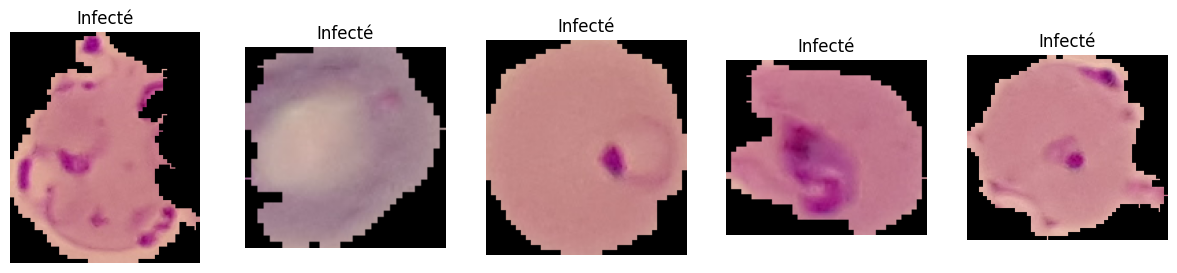

Echantillon de cellules SAINES (Propres et uniformes) :


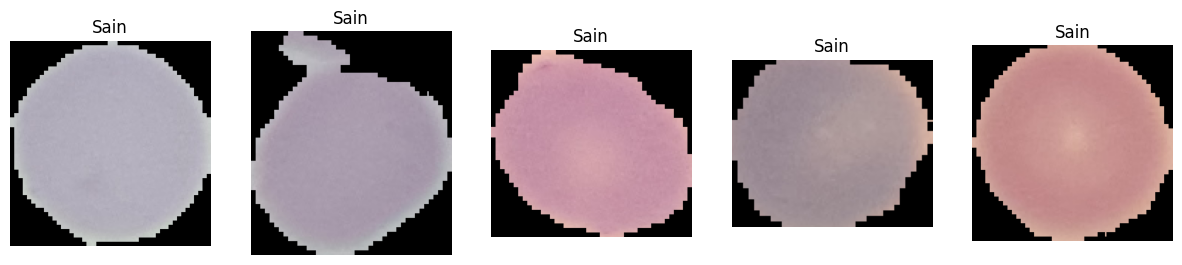

In [ ]:
# Chemins des dossiers (Assurez-vous que les données sont dézippées)
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')

# Fonction pour afficher des images aléatoires
def view_random_images(target_dir, num_images=5, title_class=""):
    target_files = os.listdir(target_dir)
    selected_files = random.sample(target_files, num_images)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(selected_files):
        img_path = os.path.join(target_dir, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(title_class)
        plt.axis('off') # Enlever les axes pour la clarté
    plt.show()

# Affichage
print("Echantillon de cellules INFECTÉES (Notez les taches violettes) :")
view_random_images(parasitized_dir, title_class="Infecté")

print("Echantillon de cellules SAINES (Propres et uniformes) :")
view_random_images(uninfected_dir, title_class="Sain")

**Analyse de l'équilibre des classes**

Pour que l'examen soit juste, il faut que l'IA s'entraîne autant sur des cas malades que sur des cas sains. Si elle ne voit que des cas sains, elle ne saura jamais reconnaître la maladie. Ce graphique compte le nombre d'images dans chaque catégorie. Idéalement, les deux barres doivent avoir la même hauteur.

Nombre d'images Infectées : 13780
Nombre d'images Saines    : 13780


/tmp/ipython-input-2174222551.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=['red', 'green'])


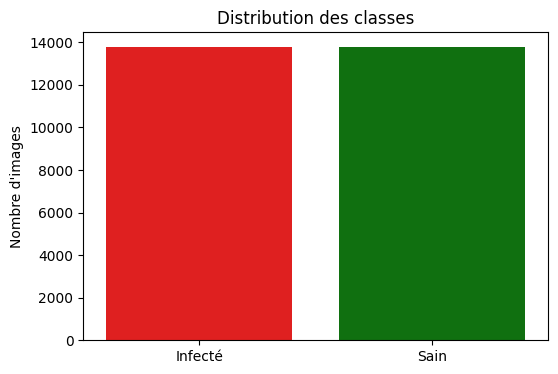

In [ ]:
# Compter les fichiers
num_parasitized = len(os.listdir(parasitized_dir))
num_uninfected = len(os.listdir(uninfected_dir))

print(f"Nombre d'images Infectées : {num_parasitized}")
print(f"Nombre d'images Saines    : {num_uninfected}")

# Graphique à barres
classes = ['Infecté', 'Sain']
counts = [num_parasitized, num_uninfected]

plt.figure(figsize=(6, 4))
sns.barplot(x=classes, y=counts, palette=['red', 'green'])
plt.title("Distribution des classes")
plt.ylabel("Nombre d'images")
plt.show()

**Définition de modèle**

C'est ici que nous assemblons notre réseau de neurones. Nous utilisons une architecture CNN (Convolutional Neural Network), qui imite la vision humaine :

    Les couches Conv2d agissent comme des yeux : elles scannent l'image pour trouver des formes (bords, taches).

    Les couches Linear (ou Dense) agissent comme le cerveau : elles analysent ces formes pour prendre une décision finale (0 ou 1).

In [ ]:
class MalariaCNN(nn.Module):
    def __init__(self):
        super(MalariaCNN, self).__init__()

        # Bloc 1 : Convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU() # Fonction d'activation
        self.pool = nn.MaxPool2d(2, 2) # Réduit l'image par 2

        # Bloc 2 : Convolution
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # Bloc 3 : Couches linéaires (Classification)
        # Après 2 pooling (64/2/2 = 16), l'image fait 16x16 avec 32 filtres
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 1) # Sortie unique (0 ou 1)
        self.sigmoid = nn.Sigmoid() # Pour avoir une probabilité entre 0 et 1

    def forward(self, x):
        # On définit le chemin de l'image à travers les couches
        x = self.pool(self.relu(self.conv1(x))) # Passe dans bloc 1
        x = self.pool(self.relu(self.conv2(x))) # Passe dans bloc 2
        x = self.flatten(x)                     # Aplatit l'image
        x = self.relu(self.fc1(x))              # Neurones classiques
        x = self.sigmoid(self.fc2(x))           # Résultat final
        return x

# Création d'une instance du modèle et envoi sur le GPU/CPU
model = MalariaCNN().to(device)
print(model)

MalariaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


**Boucle d'entraînement et sauvegarder la précision et les perdes**

C'est l'étape la plus longue. Le modèle va voir les images d'entraînement plusieurs fois (ce qu'on appelle des epochs). À chaque image, il fait une devinette. S'il se trompe, l'optimiseur corrige légèrement les connexions neuronales pour réduire l'erreur la prochaine fois. Vous verrez la "Loss" (l'erreur) diminuer et l' "Accuracy" (la précision) augmenter progressivement.

In [ ]:
# Listes pour stocker les résultats pour les graphiques
history_train_loss = []
history_train_acc = []
history_val_loss = []
history_val_acc = []

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

print("Début de l'entraînement avec suivi...")

for epoch in range(num_epochs):
    # --- PARTIE ENTRAÎNEMENT ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calcul précision train
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calcul moyennes pour cette époque
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    history_train_loss.append(epoch_loss)
    history_train_acc.append(epoch_acc)

    # --- PARTIE VALIDATION (Pour le graphique) ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val
    history_val_loss.append(epoch_val_loss)
    history_val_acc.append(epoch_val_acc)

    print(f"Époque [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.2f}%")

print("Entraînement terminé !")

Début de l'entraînement avec suivi...
Époque [1/5] | Train Loss: 0.1228 Acc: 95.80% | Val Loss: 0.1366 Acc: 95.41%
Époque [2/5] | Train Loss: 0.1109 Acc: 96.08% | Val Loss: 0.1398 Acc: 95.46%
Époque [3/5] | Train Loss: 0.1010 Acc: 96.45% | Val Loss: 0.1318 Acc: 95.75%
Époque [4/5] | Train Loss: 0.0912 Acc: 96.84% | Val Loss: 0.1416 Acc: 95.66%
Époque [5/5] | Train Loss: 0.0826 Acc: 97.08% | Val Loss: 0.1527 Acc: 95.36%
Entraînement terminé !


**Calcul de la précision**

Ces graphiques nous disent si l'entraînement s'est bien passé.

    Précision (gauche) : La courbe doit monter.

    Erreur (droite) : La courbe doit descendre.

    Si la courbe de "Validation" s'éloigne trop de la courbe "Train", le modèle est peut-être en train d'apprendre par cœur (surentraînement) au lieu de comprendre la logique.

In [ ]:
model.eval() # Mode évaluation (bloque l'apprentissage)
correct = 0
total = 0

# On désactive le calcul des gradients pour économiser de la mémoire
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        # Si probabilité > 0.5, on considère que c'est 1 (Uninfected), sinon 0 (Parasitized)
        predicted = (outputs > 0.5).float()

        # Attention : ImageFolder met 0 pour la 1ère classe par ordre alpha (Parasitized)
        # et 1 pour la 2ème (Uninfected)

        total += labels.size(0)
        # On doit adapter la forme des labels pour comparer
        correct += (predicted.view(-1) == labels).sum().item()

accuracy = 100 * correct / total
print(f'Précision sur le set de validation : {accuracy:.2f}%')

Précision sur le set de validation : 95.36%


**Courbe d'apprentissage**

Ces graphiques nous disent si l'entraînement s'est bien passé.

    Précision (gauche) : La courbe doit monter.

    Erreur (droite) : La courbe doit descendre.

    Si la courbe de "Validation" s'éloigne trop de la courbe "Train", le modèle est peut-être en train d'apprendre par cœur (surentraînement) au lieu de comprendre la logique.

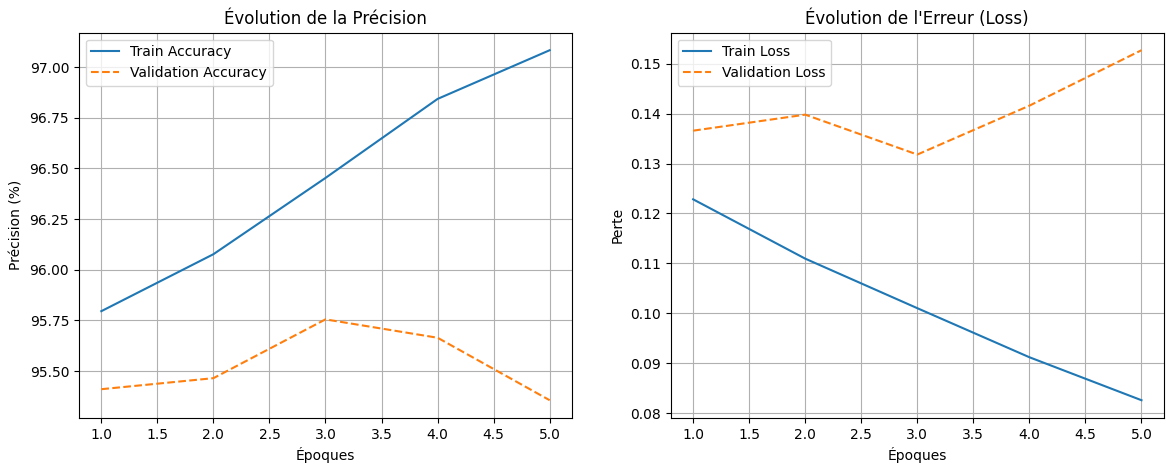

In [ ]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# Graphique 1 : Précision (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_train_acc, label='Train Accuracy')
plt.plot(epochs_range, history_val_acc, label='Validation Accuracy', linestyle='--')
plt.title('Évolution de la Précision')
plt.xlabel('Époques')
plt.ylabel('Précision (%)')
plt.legend()
plt.grid(True)

# Graphique 2 : Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_train_loss, label='Train Loss')
plt.plot(epochs_range, history_val_loss, label='Validation Loss', linestyle='--')
plt.title("Évolution de l'Erreur (Loss)")
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.show()

**Matrice de confusion**

Un simple score de précision ne suffit pas en médecine. Nous voulons savoir quel type d'erreur le modèle commet. Cette matrice compare les prédictions (ce que l'IA a dit) avec la réalité.

    Le point le plus critique est le coin en bas à gauche (Faux Négatifs) : ce sont les malades que l'IA a déclaré sains par erreur. Il faut que ce chiffre soit le plus bas possible.

<Figure size 800x600 with 0 Axes>

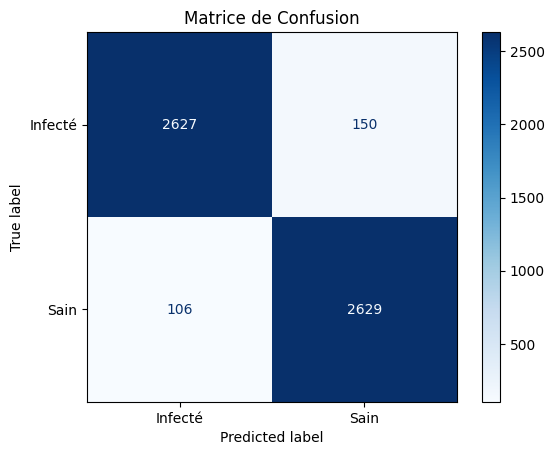

Cellules infectées bien détectées : 2627
Cellules saines bien détectées    : 2629
FAUSSES ALERTES (Sain -> Infecté) : 150
DANGER (Infecté -> Sain)          : 106


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# 1. Récupérer toutes les prédictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = (outputs > 0.5).float()

        # On remet sur le CPU pour utiliser sklearn
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. Calculer la matrice
# Attention : 0 = Parasitized (Infecté), 1 = Uninfected (Sain)
cm = confusion_matrix(all_labels, all_preds)

# 3. Affichage design
plt.figure(figsize=(8, 6))
# On utilise les noms de classes corrects
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Infecté', 'Sain'])
disp.plot(cmap=plt.cm.Blues, values_format='d') # 'd' pour afficher des entiers.
plt.title('Matrice de Confusion')
plt.show()

# 4. Analyse textuelle rapide
tn, fp, fn, tp = cm.ravel()
print(f"Cellules infectées bien détectées : {tn}")
print(f"Cellules saines bien détectées    : {tp}")
print(f"FAUSSES ALERTES (Sain -> Infecté) : {fp}")
print(f"DANGER (Infecté -> Sain)          : {fn}")

**Visualisation**

Maintenant que le modèle est entraîné, testons-le comme si nous étions un médecin avec un nouveau patient. Ce code prend une image au hasard que le modèle n'a jamais vue, affiche l'image et donne le diagnostic de l'IA avec son degré de certitude (probabilité).

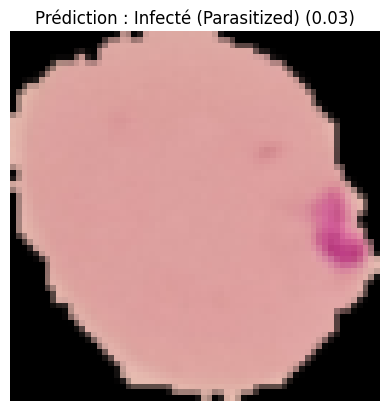

In [ ]:
# Prendre un petit lot d'images
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Faire une prédiction sur la première image du lot
model.eval()
img = images[0].unsqueeze(0).to(device) # Ajouter une dimension batch
prediction = model(img).item()

# Affichage
plt.imshow(images[0].permute(1, 2, 0)) # PyTorch met les couleurs en premier (C,H,W), il faut changer pour Matplotlib (H,W,C)
label_text = "Sain (Uninfected)" if prediction > 0.5 else "Infecté (Parasitized)"
plt.title(f"Prédiction : {label_text} ({prediction:.2f})")
plt.axis('off')
plt.show()